# Big Data Spark Notebook 

## Importing the required Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt


## Inititate the Spark session and load the data

In [2]:
# Create a Spark session
spark = SparkSession.builder.appName("ClassificationExample").getOrCreate()

# Load the dataset into a DataFrame
data = spark.read.csv("train.csv", header=True, inferSchema=True)


## Performing basic data manipulations and splitting data into numerical and categorial columns

In [3]:
# Rename the target column to "label"
data = data.withColumnRenamed("target", "label")

# Split numerical and categorical data
categorical_columns = [col for col in data.columns if col.startswith("cat")]
continuous_columns = [col for col in data.columns if col.startswith("cont")]

data_categorical = data.select(categorical_columns)
data_numerical = data.select(continuous_columns)

### Visualize the shape of data

In [4]:
# Display shapes of categorical and numerical data
print('data_categorical count: ', data_categorical.count())
print('data_numerical count: ', data_numerical.count())

# Display basic statistics of the numerical columns
data_numerical.describe().show()


data_categorical count:  300000
data_numerical count:  300000
+-------+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------------+
|summary|               cont0|              cont1|              cont2|               cont3|              cont4|               cont5|              cont6|              cont7|              cont8|              cont9|            cont10|
+-------+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------------+
|  count|              300000|             300000|             300000|              300000|             300000|              300000|             300000|             300000|             300000|             300000|            300000|
|   mean| 

## Print the Structure 

In [5]:
# Display the first few rows of the DataFrame
data.show(5)


+---+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-----+
| id|cat0|cat1|cat2|cat3|cat4|cat5|cat6|cat7|cat8|cat9|cat10|cat11|cat12|cat13|cat14|cat15|cat16|cat17|cat18|              cont0|              cont1|             cont2|             cont3|             cont4|              cont5|              cont6|             cont7|              cont8|              cont9|            cont10|label|
+---+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-----+
|  0|  

## Visualize the distribution of the Target Variable

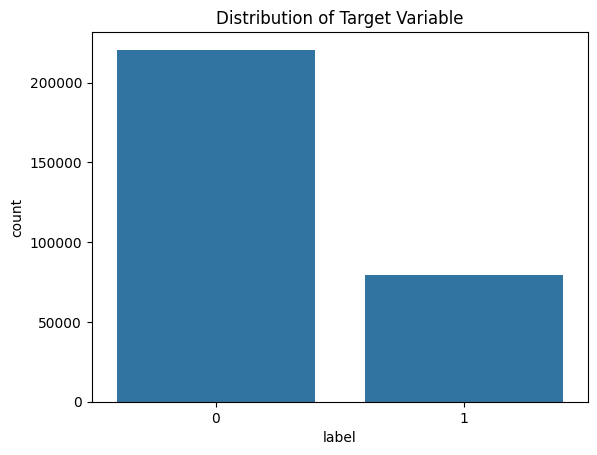

In [6]:
# Explore the distribution of the target variable
target_distribution = data.groupBy("label").count().toPandas()
sns.barplot(x="label", y="count", data=target_distribution)
plt.title("Distribution of Target Variable")
plt.show()


## Visualize the distribution of the continuous variables

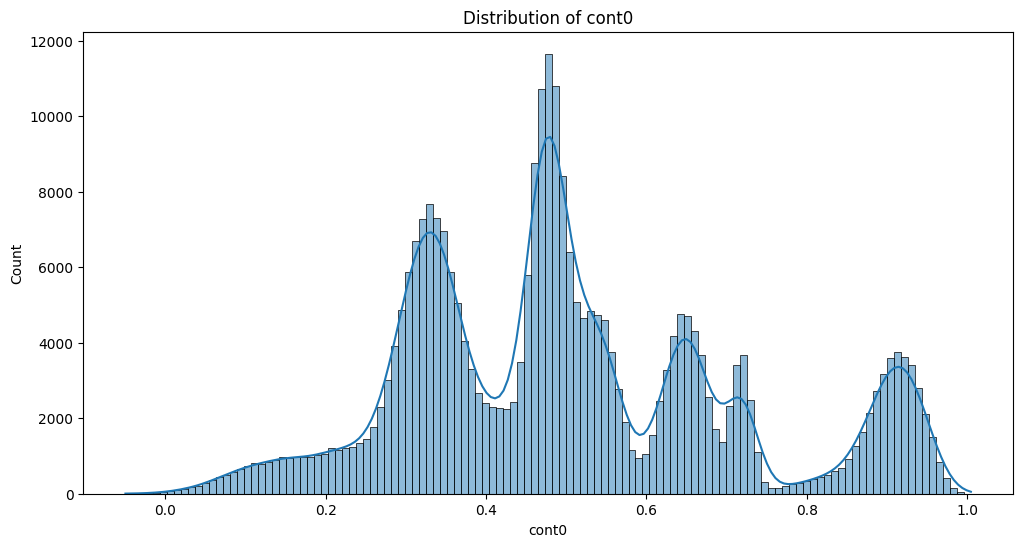

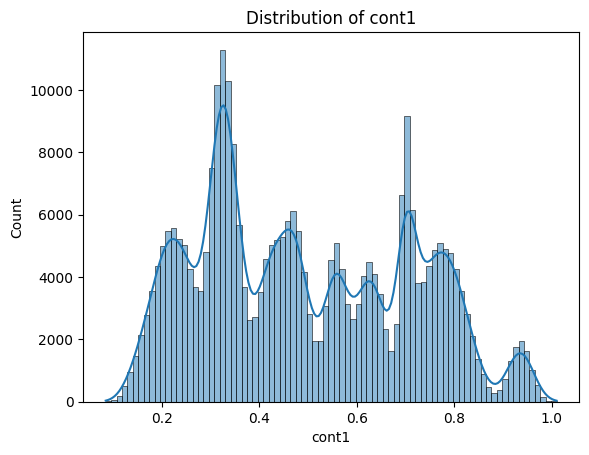

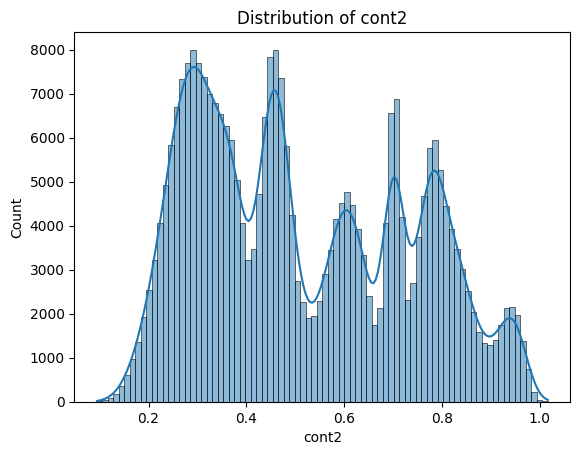

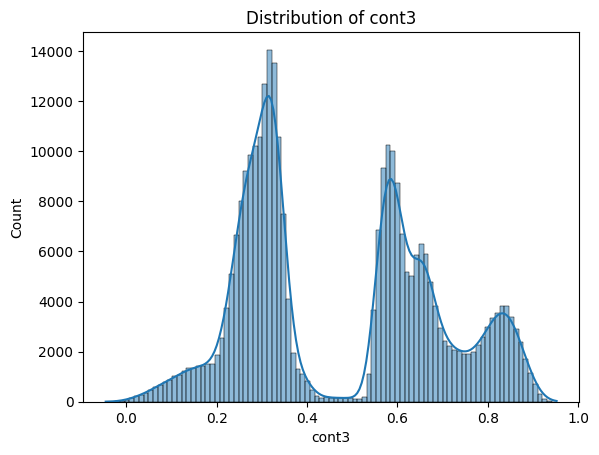

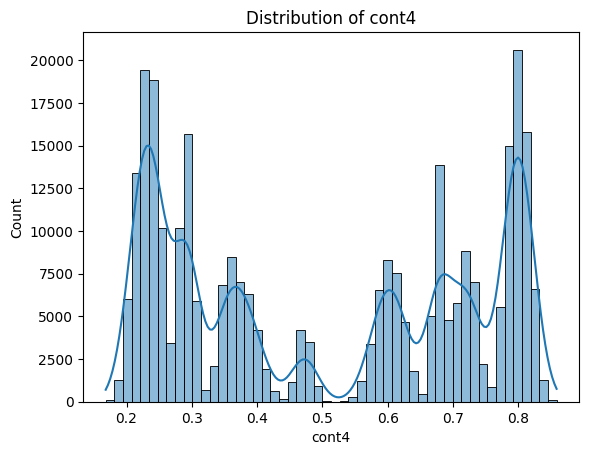

In [7]:
# Explore the distribution of some continuous variables
plt.figure(figsize=(12, 6))
for cont_col in continuous_columns[:5]:
    sns.histplot(data.toPandas(), x=cont_col, kde=True)
    plt.title(f"Distribution of {cont_col}")
    plt.show()


## Check for Nulls

In [8]:
# Data cleaning - Dealing with null values
categorical_missing_val_count = (data_categorical
                                 .toPandas()  # Convert to Pandas for local analysis
                                 .isnull().sum())
numerical_missing_val_count = (data_numerical
                               .toPandas()  # Convert to Pandas for local analysis
                               .isnull().sum())

print('categorical_missing_val_count')
print(categorical_missing_val_count[categorical_missing_val_count > 0])
print('numerical_missing_val_count')
print(numerical_missing_val_count[numerical_missing_val_count > 0])


categorical_missing_val_count
Series([], dtype: int64)
numerical_missing_val_count
Series([], dtype: int64)


## Checking for Correlation

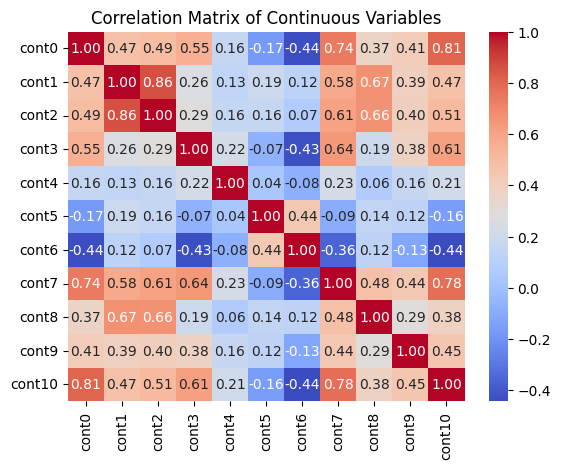

In [9]:
# Explore the correlation between continuous variables
correlation_matrix = data.select(continuous_columns).toPandas().corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Continuous Variables")
plt.show()

# Preprocessing for Pipeline Building

##                  Convert categorical string values into numeric indices.

In [10]:
# Apply StringIndexer to convert string values to numeric
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in categorical_columns]


## Convert categorical indices into a binary vector

In [11]:

# Apply OneHotEncoder to the indexed categorical columns
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_columns]


## Conatenating the two lists

In [12]:

# Create a list of stages for the pipeline
stages = indexers + encoders


## Creating a vector assembler to combine the multiple columns into a single vector column

In [13]:
# Create a vector assembler to combine the feature columns
assembler = VectorAssembler(inputCols=[col + "_encoded" for col in categorical_columns] + continuous_columns, outputCol="features")
stages.append(assembler)


## Create instances of three classification models  

In [14]:
# Create classification models with unique raw prediction and probability column names
lr = LogisticRegression(rawPredictionCol="rawPrediction_lr", probabilityCol="probability_lr", predictionCol="logreg_prediction")
dt = DecisionTreeClassifier(rawPredictionCol="rawPrediction_dt", probabilityCol="probability_dt", predictionCol="DeciTree_prediction")
rf = RandomForestClassifier(rawPredictionCol="rawPrediction_rf", probabilityCol="probability_rf", predictionCol="RandomForest_prediction")


## Add the 3 models to the existing list of stages in the pipeline

In [15]:
# Add models to the stages
stages.extend([lr, dt, rf])


## Create and fit the pipeline

In [16]:
# Create a Pipeline
pipeline = Pipeline(stages=stages)

# Fit the pipeline to the data
pipeline_model = pipeline.fit(data)

## Implement a 80-20 random split on the data to divide into train and test sets

In [17]:

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)


## Predictions on the test data

In [18]:
# Make predictions on the test data
predictions = pipeline_model.transform(test_data)


# Evaluation

In [19]:
# Evaluate the models using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()


## Logistic Regression

In [20]:
# Evaluate Logistic Regression
area_under_curve_lr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC", evaluator.rawPredictionCol: "rawPrediction_lr"})
print("Logistic Regression - Area Under ROC Curve (AUC):", area_under_curve_lr)


Logistic Regression - Area Under ROC Curve (AUC): 0.8835897506826204


## Decision Tree

In [21]:
# Evaluate Decision Tree
area_under_curve_dt = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC", evaluator.rawPredictionCol: "rawPrediction_dt"})
print("Decision Tree - Area Under ROC Curve (AUC):", area_under_curve_dt)



Decision Tree - Area Under ROC Curve (AUC): 0.5193254175866667


## Random Forest

In [22]:
# Evaluate Random Forest
area_under_curve_rf = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC", evaluator.rawPredictionCol: "rawPrediction_rf"})
print("Random Forest - Area Under ROC Curve (AUC):", area_under_curve_rf)


Random Forest - Area Under ROC Curve (AUC): 0.8569015146818388


## Stop the spark session

In [47]:

# Stop the Spark session
spark.stop()